In [8]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# This makes your plots look a bit more professional
sns.set_theme(style="whitegrid")

In [9]:
# Load the data - adjust path if necessary
movies = pd.read_csv('../data/tmdb_5000_movies.csv')

def extract_genres(genre_str):
    genres = []
    for i in ast.literal_eval(genre_str):
        genres.append(i['name'])
    return genres

movies['genres_list'] = movies['genres'].apply(extract_genres)

# Preview the data
print(f"Dataset Loaded: {movies.shape[0]} movies")
movies[['original_title', 'genres_list']].head()

Dataset Loaded: 4803 movies


,original_title,genres_list
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]"
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]"
2,Spectre,"[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]"
4,John Carter,"[Action, Adventure, Science Fiction]"


In [10]:
# One-Hot Encoding
genres_encoded = movies['genres_list'].explode().str.get_dummies().groupby(level=0).sum()

# Combine numeric features with our new genre columns
# We use .copy() to avoid the "SettingWithCopyWarning"
X = pd.concat([movies[['budget', 'popularity', 'runtime']], genres_encoded], axis=1).copy()
y = movies['revenue']

# Impute missing values
X['runtime'] = X['runtime'].fillna(X['runtime'].median())
X['budget'] = X['budget'].fillna(X['budget'].median())
X = X.fillna(0)

print(f"Features prepared. Total columns: {X.shape[1]}")

Features prepared. Total columns: 23


In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (important for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Calculate Accuracy (MAE)
predictions = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, predictions)

print(f"Model Training Complete.")
print(f"Mean Absolute Error: ${mae:,.2f}")

Model Training Complete.
Mean Absolute Error: $51,155,146.27


/var/folders/kl/0msp88353r3_cbsnqqb3c6d00000gn/T/ipykernel_26412/2268767853.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=importance, palette='magma')


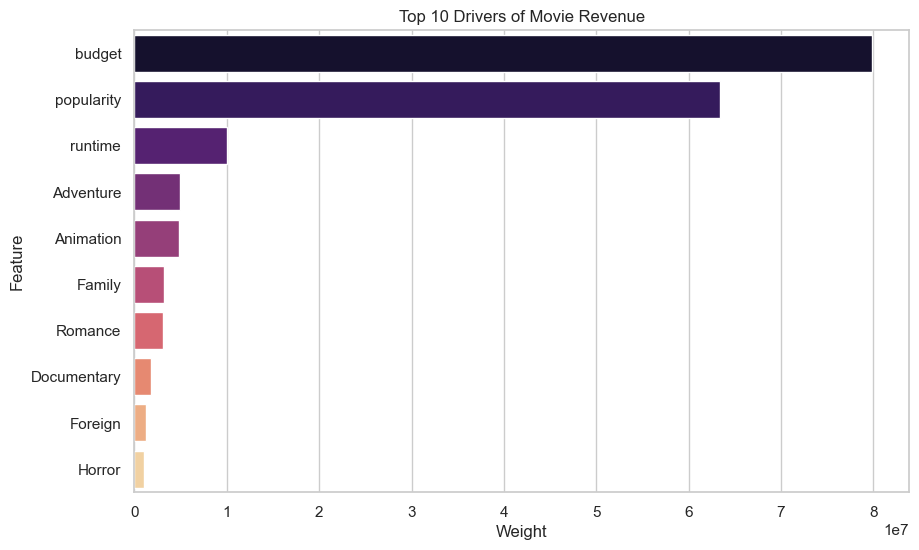

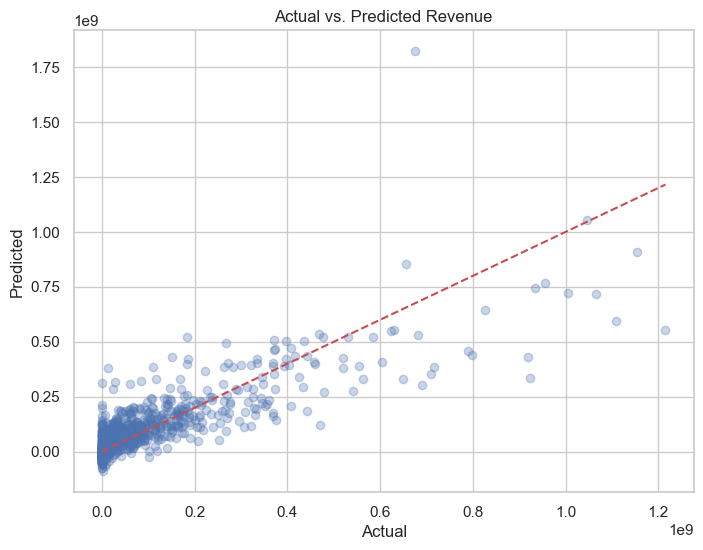

In [12]:
# 1. Feature Importance Chart
importance = pd.DataFrame({'Feature': X.columns, 'Weight': model.coef_})
importance = importance.sort_values(by='Weight', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=importance, palette='magma')
plt.title('Top 10 Drivers of Movie Revenue')
plt.show()

# 2. Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') # Diagonal line
plt.title('Actual vs. Predicted Revenue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()